# Install packages and load packages if missing
In this section, we'll ensure that all necessary packages are installed. If any of the required libraries are missing, we will install them automatically.
### Code to install missing packages:

In [ ]:
# Check if torch is installed
try:
    import torch
    print("Package 'torch' is already installed.")
except ImportError:
    print("Package 'torch' is not installed. Installing...")
    !pip install torch

# Check if scipy is installed
try:
    import scipy
    print("Package 'scipy' is already installed.")
except ImportError:
    print("Package 'scipy' is not installed. Installing...")
    !pip install scipy

import glob, pickle, os, sys
import numpy as np
import torch, torch.nn as nn, torch.optim as optim
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

device = torch.device('cpu')
print("Using device:", device)
rng = np.random.default_rng()

Package 'torch' is already installed.
Package 'scipy' is already installed.
Using device: cpu


# Set up task and generate example data

## Task description

Agents choose (sample) between two symbols to learn the hidden state associated with each symbol.  
The hidden state is an invisible colored bag:

- The **orange bag** mostly generates orange symbols but sometimes bluish ones.
- The **blue bag** mostly generates blue symbols but sometimes orangish ones.

---

## Generative model

The probability of generating a symbol of a given color is defined by:

$$
p = \frac{1}{1 + \exp(-b \cdot \text{color})}
$$

where:

- `color` is a continuous value ranging from -1 (pure blue) to +1 (pure orange).
- `b` controls the steepness of the logistic function.

---

## Evidence as Log-Likelihood Ratio (LLR)

A useful property of this generative function is that the log-likelihood ratio (LLR) is a simple linear function of the color:

$$
\text{evidence} = b \cdot \text{color}
$$

This means that the color directly provides evidence about the hidden state, making the task both interpretable and suitable for modeling.


> 💡 **Try it yourself**  
> Change the value of `error_rate` (or equivalently, change `b`) to see how the distributions change!  
>
> - A smaller `error_rate` (i.e., larger `b`) will make the two distributions more separated — symbols will be more diagnostic of the hidden bag.
> - A larger `error_rate` (i.e., smaller `b`) will make the distributions overlap — making symbols more ambiguous.
>
> 👉 Try plotting the distributions for different `error_rate` values and observe how the task becomes easier or harder.

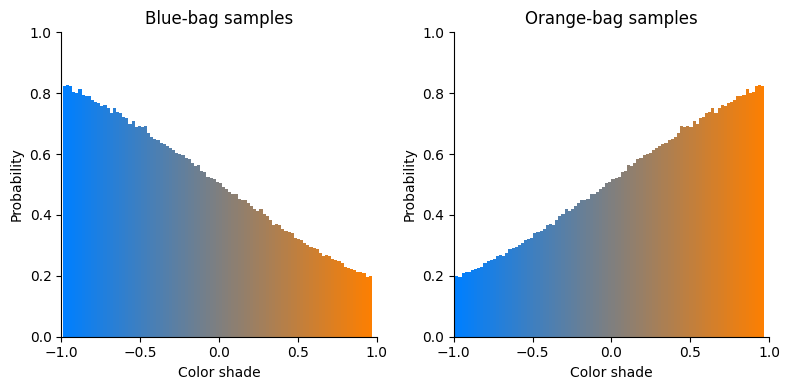

In [ ]:
error_rate = 1/3

def get_cfac(perr, resolution=0.001):
    """
    Calculate color-to-evidence based on the error rate using numerical root finding
    """
    x = np.arange(-1, 1 + resolution, resolution)
    def cfac_func(b):
        numerator = np.trapezoid(1 / (1 + np.exp(x[x > 0] * b)), x[x > 0])
        denominator = np.trapezoid(1 / (1 + np.exp(x * b)), x)
        return numerator / denominator - perr
    cfac = fsolve(cfac_func, [1.0])  # Initial guess for b

    return cfac[0]

def sample_dist(nlevel, llrfac=get_cfac(1/3)):
    """
    Probability density function for generative outcome distribution
    """
    level_list = np.arange(-nlevel, nlevel+1)/nlevel
    llr_list = level_list*llrfac
    p_gen = 1/(1+np.exp(-llr_list))
    p_gen = p_gen/p_gen.sum()

    return p_gen

# Function to interpolate between blue and orange
def interpolate_color(value, min_val, max_val):
    # Normalize the value between 0 and 1
    norm_value = (value - min_val) / (max_val - min_val)
    blue = np.array([0, 0.5, 1])
    orange = np.array([1, 0.5, 0])
    # Linear interpolation between blue and orange
    interpolated_color = (1 - norm_value) * blue + norm_value * orange
    interpolated_color = np.clip(interpolated_color * 255, 0, 255).astype(int)

    return interpolated_color

n_samples  = int(1e6)
stim_level = np.arange(-.98,1.,.02)
nlevel     = (len(stim_level)-1)/2
llr_dist   = sample_dist(nlevel, get_cfac(error_rate))
samples    = rng.choice(stim_level, p=llr_dist, size=[1, n_samples], replace=True)

# Visualize the distribution of the generated samples with color interpolation
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Blue bag: negative color samples, Orange bag: positive color samples (originally generated)
data = [(-samples.flatten(), 'Blue-bag samples'), (samples.flatten(), 'Orange-bag samples')]

for i, (sample_data, title) in enumerate(data):
    counts, bins = np.histogram(sample_data, bins=101, range=(-1, 1), density=True)

    for j in range(len(counts)):
        color = interpolate_color(bins[j], stim_level[0], stim_level[-1])
        axes[i].bar(bins[j], counts[j], width=(bins[j+1] - bins[j]), color=color/255, edgecolor='none')

    axes[i].set_title(title)
    axes[i].set_xlabel('Color shade')
    axes[i].set_ylabel('Probability')
    axes[i].spines['top'].set_visible(False)   # Remove top border
    axes[i].spines['right'].set_visible(False)  # Remove right border
    axes[i].set_xlim([-1, 1])
    axes[i].set_ylim([0, 1])

plt.tight_layout()
plt.show()

# Set up our RNN model
## The Vanilla RNN Model

The Vanilla RNN model defined here is a simple implementation of a recurrent neural network (RNN) using PyTorch.

It consists of:
- an **input-to-hidden** layer (`i2h`),
- a **hidden-to-hidden** layer (`h2h`),
- and a **hidden-to-output** layer (`h2o`).

The model uses the **tanh** (hyperbolic tangent) activation function to update its hidden state, which is influenced by both the current input and the previous hidden state.

---

## Noise mechanism

This model also includes a noise mechanism:
- Gaussian noise is added to the hidden state updates.
- The strength of this noise is controlled by the parameter `noise_value`.

> 💡 Adding noise can sometimes help improve generalization by preventing overfitting.

---

## Why use `tanh` instead of `ReLU`?

- The `tanh` activation outputs values in the range **[-1, 1]**, allowing the network to propagate both positive and negative signals.
- This is crucial for RNNs, where the hidden state often needs to encode both excitatory (positive) and inhibitory (negative) information.
- In contrast, `ReLU` outputs only non-negative values (≥ 0), which might prevent the network from properly capturing tasks that require:
    - negative feedback signals,
    - or balanced dynamics in the hidden state.

> ⚡ `tanh` helps maintain a **balanced signal flow** across time steps, which is especially important for recurrent networks.



In [ ]:
# Define vanilla RNN model
class vanillaRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, noise_value=0.0):
        # bring in methods of nn.Module into RNNModel
        super(vanillaRNN, self).__init__()
        # number of units in hidden layer
        self.hidden_dim = hidden_dim
        # noise scalar constant
        self.noise_value = noise_value
        # define layers
        self.i2h = nn.Linear(input_dim,  hidden_dim, bias=False) # input to hidden
        self.h2h = nn.Linear(hidden_dim, hidden_dim, bias=True)  # hidden to hidden
        self.h2o = nn.Linear(hidden_dim, output_dim, bias=False) # hidden to output
        # define activation functions
        self.tanh = nn.Tanh()

    def forward(self, input, hidden_prev, device):
        inp = self.i2h(input).to(device)
        hid = self.h2h(hidden_prev).to(device)

        # update hidden state
        combined = inp + hid

        # calculate noise
        if self.noise_value != 0:
            noise_samp = torch.normal(mean=torch.zeros(combined.shape, device=device),
                                      std=torch.ones(combined.shape, device=device)*self.noise_value)
        else:
            noise_samp = torch.zeros(combined.shape, device=device)

        # calculate hidden state
        hidden = self.tanh(combined + noise_samp)
        hidden.to(device)
        # calculate output
        output = self.h2o(hidden)
        output.to(device)

        return output, hidden

    def init_hidden(self, batch_size, device):
        # initialize hidden state
        return torch.zeros(batch_size, self.hidden_dim, requires_grad=True, device=device)

## Gated RNN

A **Gated Recurrent Neural Network (Gated RNN)** is an enhanced version of the vanilla RNN, designed to overcome some of its limitations, especially when dealing with long sequences.

---

## Why gating?

Traditional RNNs struggle with:
- **vanishing gradients** (information fades over time),
- **exploding gradients** (unstable learning on long sequences).

This makes it hard for vanilla RNNs to learn **long-term dependencies**.

---

## Gated RNNs: The idea

Gated RNNs introduce **gates** — specialized units that control the flow of information.  
At each time step, the network can:
- decide what information to **keep**,
- decide what information to **forget**,
- decide how much of the **new input** should update the hidden state.

---

## Benefits of Gated RNNs

- ✅ **Improved memory** — can capture long-range dependencies.
- ✅ **Stable learning** — gates help mitigate vanishing/exploding gradients.
- ✅ **Better performance** — especially useful for cognitive models, language models, and time series.

# Bonus tip: Gated RNN

In [ ]:
class GatedRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, noise_value=0.0):
        super(GatedRNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.noise_value = noise_value

        # main linear layers
        self.i2h = nn.Linear(input_dim, hidden_dim, bias=False)  # input to hidden
        self.h2h = nn.Linear(hidden_dim, hidden_dim, bias=True)  # hidden to hidden
        self.h2o = nn.Linear(hidden_dim, output_dim, bias=False) # hidden to output

        # gating layers (new)
        self.i2z = nn.Linear(input_dim, hidden_dim, bias=False)  # input to gate
        self.h2z = nn.Linear(hidden_dim, hidden_dim, bias=False) # hidden to gate

        # activation functions
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, input, hidden_prev, device):
        inp = self.i2h(input).to(device)
        hid = self.h2h(hidden_prev).to(device)

        # noise
        if self.noise_value != 0:
            noise_samp = torch.normal(mean=torch.zeros(inp.shape, device=device),
                                      std=torch.ones(inp.shape, device=device) * self.noise_value)
        else:
            noise_samp = torch.zeros(inp.shape, device=device)

        # candidate hidden state
        hidden_candidate = self.relu(inp + hid + noise_samp)

        # gating
        z = self.sigmoid(self.i2z(input) + self.h2z(hidden_prev))

        # gated hidden state update
        hidden = z * hidden_prev + (1 - z) * hidden_candidate

        # output
        output = self.h2o(hidden)

        return output, hidden

    def init_hidden(self, batch_size, device):
        return torch.zeros(batch_size, self.hidden_dim, requires_grad=True, device=device)

# Make the network move!

<img src="https://media.giphy.com/media/l0MYt5jPR6QX5pnqM/giphy.gif" width="300">

To start off, we will make the network **move** — that is, actually process inputs and update its hidden activities.

We will generate **500 sequences**, each consisting of **8 trials**.  
The network will now receive inputs and produce outputs at every trial.

But notice something:  
Although the network produces output actions, these actions are essentially **random**.  
Why?

> Because the network has no idea what the goal is — there is no objective function to be maximized yet!

The network is simply reacting to inputs without any reason to prefer one action over another.  
In the next step, we will provide it with a learning signal to guide its behavior.

probability of choosing stim 1:  tensor([0.4700, 0.5360, 0.5180, 0.5140, 0.4900, 0.5500, 0.5200, 0.4800])


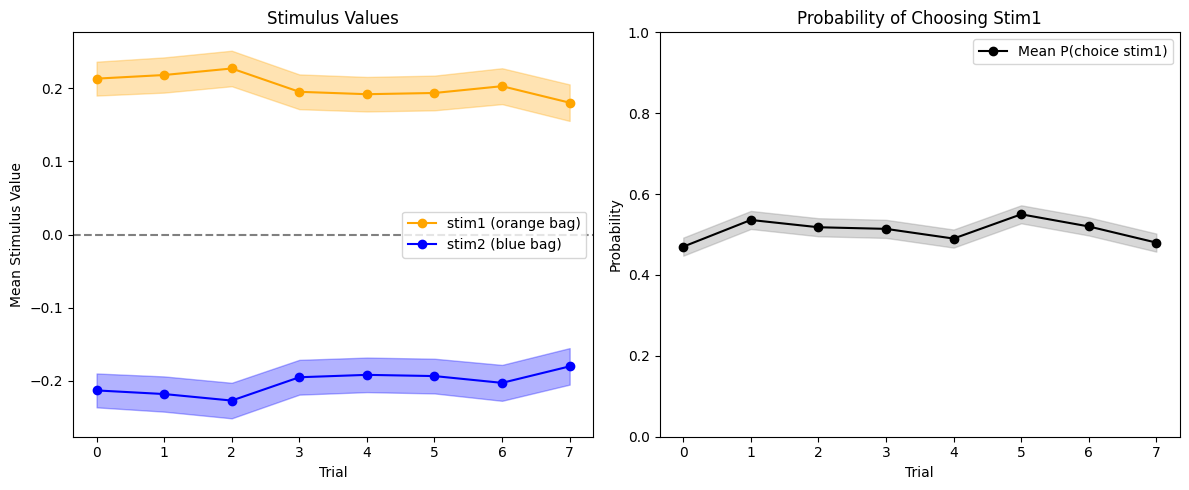

In [ ]:
input_size  = 2
output_size = 1
hidden_size = 12
# Task:
n_trials = 8
n_games  = 500

sample        = rng.choice(stim_level, p=llr_dist, size=[n_trials, n_games], replace=True) # seed samples
stim1_vectors = torch.tensor(sample, dtype=torch.float32) # orange bag
stim2_vectors = torch.tensor(-sample, dtype=torch.float32) # blue bag
input_tensor  = torch.cat((stim1_vectors.unsqueeze(2), stim2_vectors.unsqueeze(2)), dim=2)

batch_size = input_tensor.shape[1]

rnn_model = vanillaRNN(input_size, hidden_size, output_size) # assign model

action_save = torch.full([n_trials,n_games], torch.nan, device=device)

# Initialization
hidden = rnn_model.init_hidden(batch_size, device)
output = torch.zeros([batch_size, output_size]) # start from 0 (random action)
# run sampling trial loop
for t in range(n_trials):
    p_action       = torch.sigmoid(output) # output for sampling (based on last step)
    action         = torch.bernoulli(p_action).type(torch.LongTensor) # 0/1 binary choice
    input_raw      = input_tensor[t,:,:]
    input_at_t     = torch.zeros_like(input_raw)
    input_at_t     = input_at_t.scatter_(1, action, input_raw.gather(1, action)) # update the chosen
    output, hidden = rnn_model(input_at_t, hidden, device)  # forward pass
    action_save[t] = action.squeeze()

pChoice_stim1 = torch.mean((action_save==0).type(torch.float32),dim=1)
print('probability of choosing stim 1: ', pChoice_stim1)

plt.figure(figsize=(12, 5))
# Compute means and SEMs across games
stim1_mean = stim1_vectors.mean(1).cpu()
stim1_sem  = stim1_vectors.std(1).cpu() / np.sqrt(n_games)
stim2_mean = stim2_vectors.mean(1).cpu()
stim2_sem  = stim2_vectors.std(1).cpu() / np.sqrt(n_games)
trials = np.arange(n_trials)
# ----- Panel 1: mean stim1 and stim2 -----
plt.subplot(1, 2, 1)
plt.plot(trials, stim1_mean, label='stim1 (orange bag)', color='orange', marker='o')
plt.fill_between(trials, stim1_mean - stim1_sem, stim1_mean + stim1_sem, color='orange', alpha=0.3)
plt.plot(trials, stim2_mean, label='stim2 (blue bag)', color='blue', marker='o')
plt.fill_between(trials, stim2_mean - stim2_sem, stim2_mean + stim2_sem, color='blue', alpha=0.3)
plt.axhline(0, linestyle='--', color='gray')
plt.xlabel('Trial')
plt.ylabel('Mean Stimulus Value')
plt.title('Stimulus Values')
plt.legend()

# ----- Panel 2: plot pChoice_stim1 -----
# Compute mean and SEM
mean_pchoice = pChoice_stim1.cpu().numpy()
std_pchoice = torch.std((action_save==0).float(), dim=1).cpu().numpy() / np.sqrt(n_games)
trials = np.arange(n_trials)
plt.subplot(1, 2, 2)
plt.plot(trials, mean_pchoice, marker='o', color='black', label='Mean P(choice stim1)')
plt.fill_between(trials, mean_pchoice - std_pchoice, mean_pchoice + std_pchoice, color='gray', alpha=0.3)
plt.ylim(0, 1)
plt.xlabel('Trial')
plt.ylabel('Probability')
plt.title('Probability of Choosing Stim1')
plt.legend()
plt.tight_layout()
plt.show()

# Train and test RNN in the bandit task (instrumental learning)

In this section, we will train the RNN to perform the bandit-like color-sampling task.

## What is Policy Gradient?

We optimize the network using a **policy gradient** method.  
The goal is to make the network more likely to repeat actions that led to higher rewards.

---

### Idea:

- The network defines a **policy**, i.e., a probability distribution over actions:
  
  $$
  \pi_t = \big[ P(\text{choose action 0}), \ P(\text{choose action 1}) \big]
  $$

- The network samples actions based on this policy:
  
  $$
  a_t \sim \pi_t
  $$

- After each trial, it observes a **reward**:
  
  $$
  r_t = \text{observed reward}
  $$

---

### Why does the network improve?

Using policy gradient, we modify the network to:
1. **Increase** the probability of actions that resulted in high rewards.
2. **Decrease** the probability of actions that resulted in low rewards.

In other words, we want to maximize:

$$
\mathbb{E} [ r_t \cdot \log \pi_t(a_t) ]
$$

where:
- $ r_t $ is the (possibly discounted) reward.
- $ \log \pi_t(a_t) $ is the log-probability of the action actually taken.

---

### In our code:

1. `policies[t]` stores the action probabilities at trial `t`.
2. `log_probs` extracts the log-probability of the *chosen* action at each trial:
   
   $$
   \log \pi_t(a_t)
   $$

3. `discounted_rewards` contains the cumulative future reward, possibly discounted.

4. The loss is computed as:

   $$
   \text{policy loss} = -\mathbb{E}[r_t \cdot \log \pi_t(a_t)]
   $$

   In code:
   ```python
   weighted_log_probs = discounted_rewards * log_probs
   policy_loss = -weighted_log_probs.mean()


## Bandit RNN Training Loop

In the following, we define a **Bandit RNN training loop**.

We intentionally configure the network to make a **random and unbiased choice** on the first trial.  
Afterward, the network will be optimized using **policy gradient** to maximize rewards.  
In this example, the reward is given when the network correctly achieves a pre-defined goal — such as **choosing the symbol most likely to come from the orange bag**.

---

### Task Dataset Generator

We also define a `generate_games()` function, which makes it easy to generate task datasets.  
This function takes as input a **pair of hidden states** representing the two symbols and produces a sequence of trials where the network learns from interacting with these symbols.


In [ ]:
def discount(x, gamma):
    return scipy.signal.lfilter([1], [1, -gamma], x[::-1], axis=0)[::-1]

def run_loop_bandit(input_tensor, rnn_model, device, gamma=0.5):
    input_dims       = input_tensor.shape
    sequence_length  = input_dims[0]
    batch_size       = input_dims[1]
    hidden_size      = rnn_model.h2h.in_features
    # preallocate output tensors
    h_activat        = torch.full((batch_size, hidden_size, sequence_length), torch.nan, device=device)
    responses        = torch.full(input_dims[0:2], torch.nan, device=device)
    respprobs        = torch.full(input_dims[0:2], torch.nan, device=device)
    chosen_actions   = torch.zeros([sequence_length, batch_size], dtype=int)
    policies         = torch.full((sequence_length, batch_size,2), torch.nan, device=device)
    observed_rewards = torch.zeros([sequence_length + 1, batch_size])

    # Initialization
    hidden = rnn_model.init_hidden(batch_size, device)
    output = torch.zeros([batch_size, 1])

    # run training loop
    for t in range(sequence_length):

        p_action       = torch.sigmoid(output) # output for sampling (based on last step)
        action         = torch.bernoulli(p_action).type(torch.LongTensor) # 0/1 binary choice
        input_raw      = input_tensor[t,:,:]
        input_at_t     = torch.zeros_like(input_raw)
        input_at_t     = input_at_t.scatter_(1, action, input_raw.gather(1, action)) # update the chosen

        # store for output
        respprobs[t, :]     = p_action.squeeze()
        chosen_actions[t]   = action.squeeze()
        policies[t]         = torch.stack([1 - respprobs[t, :], respprobs[t, :]], dim=1)
        observed_rewards[t] = input_raw.gather(1, action).squeeze(1)
        h_activat[:, :, t]  = hidden

        output, hidden = rnn_model(input_at_t, hidden, device)  # forward pass

    policies = policies[1:,:,:] # trl 1,2,3.., trl0 is random
    observed_rewards = observed_rewards[1:,:]

    discounted_rewards = discount(observed_rewards.numpy(), gamma)[:-1]

    out = {
            'respprobs':          respprobs,
            'h_activat':          h_activat,
            'chosen_actions':     chosen_actions,
            'policies' :          policies,
            'discounted_rewards': discounted_rewards,
            }

    return out

def generate_games(n_trials, n_games, conditions=[(1,0)]):
    # configuration
    n = int(np.floor(n_games))
    stim_level = np.arange(-.98,1.,.02)
    nlevel = (len(stim_level)-1)/2
    # Calculate the LLR distribution
    llr_dist = sample_dist(nlevel)
    # Initialize lists for stacking stim1, stim2, target
    stim1_all, stim2_all, target_s1, target_s2 = [], [], [], []
    # Loop over conditions (# hidden states (targets)):
    for condition in conditions:
        s1, s2 = condition
        # Generate the samples for current condition
        sample = rng.choice(stim_level,
                            p=llr_dist,
                            size=[n, n_trials],
                            replace=True)
        # Determine stim1_vectors and stim2_vectors
        stim1_vectors = sample if s1 == 1 else -sample # orange(1) means mostly positive values
        stim2_vectors = sample if s2 == 1 else -sample # blue(0) means mostly negative values
        # Stack
        stim1_all.append(stim1_vectors)
        stim2_all.append(stim2_vectors)
        # Create target labels
        target_s1.append(np.full((n,), s1))
        target_s2.append(np.full((n,), s2))
    # Stack all conditions into final tensors
    stim1_all = torch.cat([torch.tensor(x, dtype=torch.float32) for x in stim1_all], dim=0)
    stim2_all = torch.cat([torch.tensor(x, dtype=torch.float32) for x in stim2_all], dim=0)
    target_s1 = torch.cat([torch.tensor(x, dtype=torch.float32) for x in target_s1], dim=0)
    target_s2 = torch.cat([torch.tensor(x, dtype=torch.float32) for x in target_s2], dim=0)
    # Combine target_s1 and target_s2 into a single tensor
    target    = torch.stack((target_s1, target_s2), dim=0) # Shape (2, n_games)
    perm      = torch.randperm(stim1_all.size(0)) # shuffle
    stim1_all = stim1_all[perm].T
    stim2_all = stim2_all[perm].T
    target    = target[:, perm].T
    # Return the stacked variables
    return stim1_all, stim2_all, target

from scipy.stats import truncnorm
def generate_restless(n_trials, n_games):
    # Generate drifting probability over time (restless bandit dynamics)
    proba_r = np.zeros([n_trials, n_games]) + 0.5
    for t in range(1, n_trials):
        a, b = (0 - proba_r[t-1]) / 0.108, (1 - proba_r[t-1]) / 0.108
        proba_r[t] = truncnorm.rvs(a, b, loc=proba_r[t-1], scale=0.108)

    # Generate reward probabilities for the two options
    a, b = (0 - proba_r) / 0.153, (1 - proba_r) / 0.153
    rewards = np.zeros([n_trials, n_games, 2])
    rewards[:, :, 0] = truncnorm.rvs(a, b, loc=proba_r, scale=0.153)  # stim1
    rewards[:, :, 1] = 1 - rewards[:, :, 0]                           # stim2

    # Convert to torch tensors and shift to [-0.5, 0.5]
    stim1 = torch.tensor(rewards[:, :, 0], dtype=torch.float32) - 0.5  # shape [n_trials, n_games]
    stim2 = torch.tensor(rewards[:, :, 1], dtype=torch.float32) - 0.5  # shape [n_trials, n_games]

    # Dummy target to match function signature
    target = torch.zeros(n_games, 2)  # same shape as target in generate_games()

    return stim1, stim2, target


## Training a Small RNN on the Bandit Task

Now, we can generate **500 games** (sequences) and train a small RNN with only **6 hidden units**.

With just **300 training epochs**, the network already achieves around **80% accuracy**.

---

> 💡 **Bonus question:**  
> What happens if we try the same with a *restless random walk bandit task*?


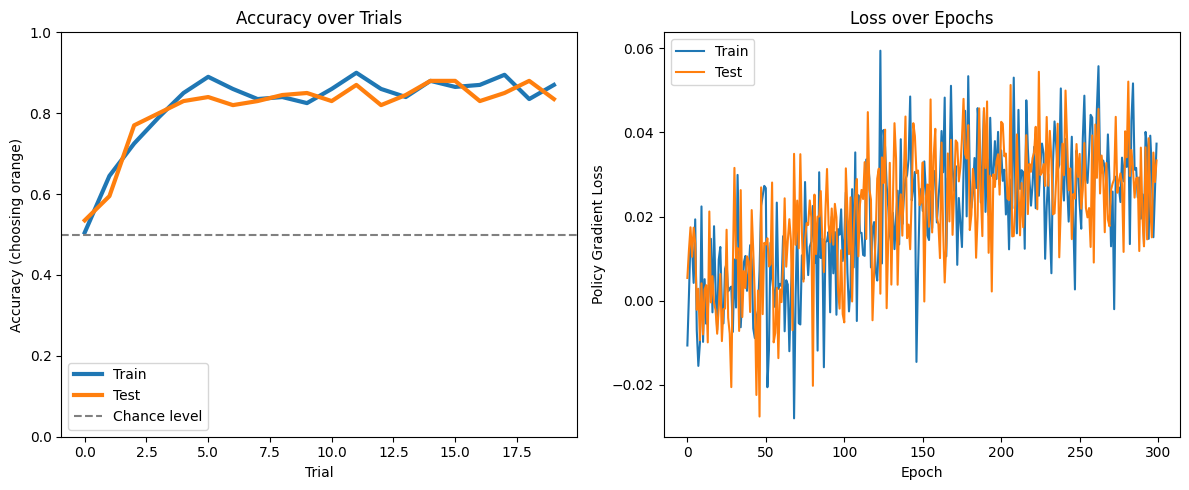

In [ ]:
# --- Parameters ---
n_trials = 20
n_games = 200
max_epochs = 300
learning_rate = 0.0005
input_size = 2
output_size = 1
hidden_size = 6
gamma = 0.5

# --- Model & Optimizer ---
rnn = vanillaRNN(input_size, hidden_size, output_size).to(device)
optimizer = optim.Adam(rnn.parameters(), lr=learning_rate, amsgrad=True, eps=1e-6)

loss_totals = {"train": [], "test": []}
accTime = {"train": [], "test": []}
batch_types = ["train", "test"]

# --- Training loop ---
for epoch in range(max_epochs):
    for batch_type in batch_types:

        stim1, stim2, _ = generate_games(n_trials, n_games)
        # stim1, stim2, _ = generate_restless(n_trials, n_games)
        input_tensor = torch.cat((stim1.unsqueeze(2), stim2.unsqueeze(2)), dim=2)

        if batch_type == "train":
            optimizer.zero_grad()
            rnn.train()
            output = run_loop_bandit(input_tensor, rnn, device, gamma)

        else:  # validation
            rnn.eval()
            with torch.no_grad():
                output = run_loop_bandit(input_tensor, rnn, device, gamma)

        chosen_actions = output["chosen_actions"]
        policies = output["policies"]
        discounted_rewards = output["discounted_rewards"]

        # --- Policy gradient loss ---
        log_probs = torch.log(torch.gather(policies, 2, chosen_actions[1:, :].unsqueeze(-1)).squeeze(-1))
        discounted_rewards = torch.tensor(discounted_rewards.copy(), dtype=log_probs.dtype, device=device)
        weighted_log_probs = log_probs * discounted_rewards
        policy_loss = -weighted_log_probs.mean()
        loss = policy_loss

        # --- Accuracy ---
        accuracy = torch.mean((chosen_actions == 0).float(), dim=1)
        accTime[batch_type] = accuracy
        loss_totals[batch_type].append(loss.item())

        # --- Backprop (train only) ---
        if batch_type == "train":
            loss.backward()
            optimizer.step()

# --- Plotting ---
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
# Accuracy curves
for batch_type in ["train", "test"]:
    axs[0].plot(accTime[batch_type], label=batch_type.capitalize(),linewidth=3)
axs[0].axhline(0.5, linestyle='--', color='gray', label='Chance level')
axs[0].set_xlabel('Trial')
axs[0].set_ylabel('Accuracy (choosing orange)')
axs[0].set_title('Accuracy over Trials')
axs[0].legend()
axs[0].set_ylim([0, 1])

# Loss curves
for batch_type in ["train", "test"]:
    axs[1].plot(loss_totals[batch_type], label=batch_type.capitalize())
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Policy Gradient Loss')
axs[1].set_title('Loss over Epochs')
axs[1].legend()
plt.tight_layout()
plt.show()

# Train and test RNN in the GUESS task (structure learning)

### Setting up the RNN for the GUESS (Structure Learning) Task

In this section, we will set up the RNN to learn and perform the **GUESS** task, which is a structure learning problem. In this task, the agent is not freely sampling between the two symbols, nor is there any prospective goal regarding which colored bag is the target. Instead, the agent is only required to make a **retrospective judgment** at the end of each game: it has to guess which bag each symbol was drawn from.

To train the RNN, we first use a **cross-entropy loss function** to optimize the network to match its predictions to the hidden state targets (i.e., the bag colors). Importantly, the agent needs to correctly infer the hidden states of **both** symbols within a game; otherwise, its performance will remain at chance level.

In this implementation, we provide the RNN with **three output units**:
- The first output is for making choices (analogous to a motor cortex).
- The additional two outputs are used as **state representations**, responsible for inferring and tracking the hidden states associated with the two symbols.

Since the agent needs to infer the hidden states of **both symbols**, the total loss is:

$$
L = L_1 + L_2 = -\sum_{i} y_{1,i} \log(p_{1,i}) - \sum_{i} y_{2,i} \log(p_{2,i})
$$

where:
- $L_1$ is the cross-entropy loss for the first symbol,
- $L_2$ is the cross-entropy loss for the second symbol.

where:
- $ y \in \{0, 1\} $ is the target label,
- $ p \in (0,1) $ is the predicted probability (output of a sigmoid function).

If the agent predicts the correct hidden states for both symbols, it will minimize the BCE loss and achieve good performance in the task.

### Example: Binary Cross-Entropy Loss

Suppose the true label is \( y = 1 \) (the correct bag is **orange**).

---

**Good prediction**

The RNN predicts \( p = 0.9 \) (high confidence for the correct class):

$$
L = -\left[1 \cdot \log(0.9) + (1 - 1) \cdot \log(1 - 0.9)\right]
$$

This simplifies to:

$$
L = -\log(0.9) \approx 0.105
$$

Since the prediction is correct and confident, the loss is small.

---

**Bad prediction**

The RNN predicts \( p = 0.1 \) (low probability for the correct class):

$$
L = -\left[1 \cdot \log(0.1) + (1 - 1) \cdot \log(1 - 0.1)\right]
$$

Simplifies to:

$$
L = -\log(0.1) \approx 2.302
$$

Since the prediction is wrong and confident, the loss is large.

In [ ]:
def run_loop_guess(input_tensor, rnn_model, device):

    input_dims       = input_tensor.shape
    sequence_length  = input_dims[0]
    batch_size       = input_dims[1]
    hidden_size      = rnn_model.h2h.in_features

    # preallocate output tensors
    h_activat        = torch.full((batch_size, hidden_size, sequence_length), torch.nan, device=device)
    responses        = torch.full(input_dims[0:2], torch.nan, device=device)
    respprobs        = torch.full(input_dims[0:2], torch.nan, device=device)
    chosen_actions   = torch.zeros([sequence_length, batch_size], dtype=int)
    policies         = torch.full((sequence_length, batch_size,2), torch.nan, device=device)
    cum_value_T    = torch.zeros([sequence_length, batch_size, 2])
    evidence       = torch.zeros([sequence_length, batch_size,2])
    p_states       = torch.zeros([sequence_length, batch_size,2])
    policies       = torch.full((sequence_length, batch_size,2), torch.nan, device=device)
    belief_min     = torch.zeros([sequence_length + 1, batch_size])

    # Initialization
    hidden = rnn_model.init_hidden(batch_size, device)
    cumulative_input = torch.zeros_like(input_tensor[0,:,:])
    output = torch.zeros([batch_size, 3])

    # run training loop
    for t in range(sequence_length):

        p_action       = torch.sigmoid(output[:,0]) # output for sampling (based on last step)
        action         = torch.bernoulli(p_action).type(torch.LongTensor).unsqueeze(1) # 0/1 binary choice
        input_raw      = input_tensor[t,:,:]
        input_at_t     = torch.zeros_like(input_raw)
        input_at_t     = input_at_t.scatter_(1, action, input_raw.gather(1, action)) # update the chosen

        # store for output
        respprobs[t, :]     = p_action.squeeze()
        chosen_actions[t]   = action.squeeze()
        policies[t]         = torch.stack([1 - respprobs[t, :], respprobs[t, :]], dim=1)
        h_activat[:, :, t]  = hidden

        # hidden-states inference:
        evidence[t,:,:]     = output[:, 1:].squeeze() # raw RNN outputs
        p_states[t,:,:]     = torch.sigmoid(evidence[t,:,:]) # 2 RNN outputs for state predictions
        belief              = torch.abs(evidence[t,:,:]) # RNN belief
        belief_min[t]       = torch.min(belief[:, 0], belief[:, 1]) # to be maximized

        cumulative_input   += input_at_t
        cum_value_T[t]      = cumulative_input

        output, hidden = rnn_model(input_at_t, hidden, device)  # forward pass

    # Out-of-sample prediction: i.e., trial n + 1
    evidence_ex = output[:, 1:].squeeze()
    p_states_ex = torch.sigmoid(evidence_ex) # output for final question (only for 'guess' condition)

    belief_ex = torch.abs(evidence_ex)
    belief_min[sequence_length] = torch.min(belief_ex[:, 0], belief_ex[:, 1]) # to be maximized

    policies = policies[1:,:,:] # trl 1,2,3.., trl0 is random
    belief_min = belief_min[2:,:].detach() # trl 2,3,4...as actions' consequences

    out = { 'p_states':       p_states,
            'p_states_ex':    p_states_ex,
            'evidence':       evidence,
            'evidence_ex':    evidence_ex,
            'respprobs':      respprobs,
            'responses':      responses,
            'h_activat':      h_activat,
            'cum_value_T':    cum_value_T,
            'chosen_actions': chosen_actions,
            'policies' :      policies,
            'belief_min':     belief_min,
        }

    return out

### Training the RNN with Cross-Entropy Loss on a Fully-Balanced Dataset

Let's now train a cross-entropy-loss based RNN on a fully-balanced dataset containing both:
- **Counterfactual conditions**: one bag is orange, and the other bag is blue.
- **Non-counterfactual conditions**: both bags are orange or both are blue.

We will examine whether the RNN's **out-of-sample prediction accuracy** increases as a function of **sequence length**.

In addition, we will visualize the **low-dimensional representation** of the hidden layer activity to gain insight into how the network internally represents information during learning.

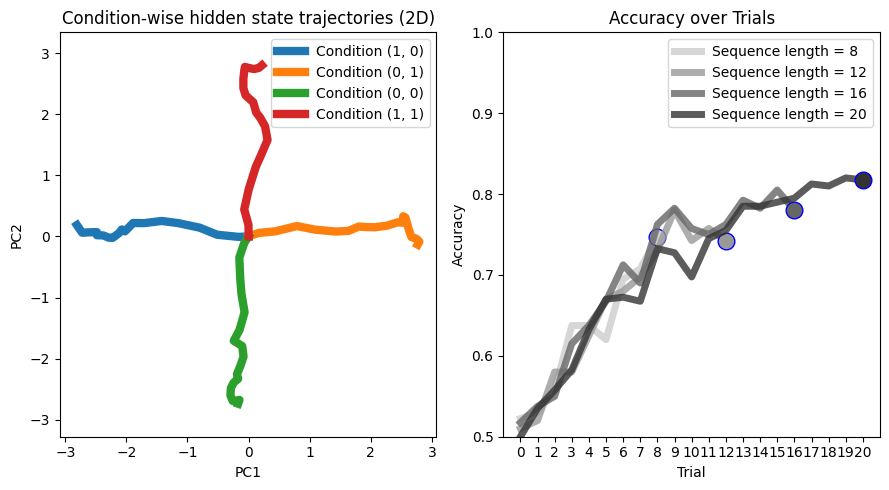

In [ ]:
# Task parameters
n_trials    = 20
n_games     = 25

# Network parameters
max_epochs   = 500
learning_rate = 0.0005
input_size   = 2
output_size  = 3
hidden_size  = 48

conditions = [(1, 0), (0, 1), (0, 0), (1, 1)]
# Mixed four conditions: counterfactual & non-counterfactual

# Model & optimizer
rnn = vanillaRNN(input_size, hidden_size, output_size).to(device)
optimizer = optim.Adam(rnn.parameters(), lr=learning_rate, amsgrad=True, eps=1e-6)
bce_loss = nn.BCELoss()

torch.set_grad_enabled(True)

# Data containers
batch_types = ["train", "test"]
acc_totals = {bt: [] for bt in batch_types}
accTime = {bt: [] for bt in batch_types}

# Training loop
for epoch in range(max_epochs):
    for batch_type in batch_types:

        if batch_type == "train":
            rnn.train()
            optimizer.zero_grad()
            sequence_lengths = [n_trials]
        else:
            rnn.eval()
            sequence_lengths = [8, 12, 16, n_trials]  # variable-length test batches

        loss_x_ent  = torch.full((len(sequence_lengths), 1), torch.nan, device=device)
        policy_loss = torch.full((len(sequence_lengths), 1), torch.nan, device=device)
        accuracy = {}
        choice = {}
        cum_value = {}

        # Loop over mini-batches of different sequence lengths
        for i, ntrl_minibatch in enumerate(sequence_lengths):

            stim1, stim2, target = generate_games(ntrl_minibatch, n_games, conditions)
            input_tensor = torch.cat((stim1.unsqueeze(2), stim2.unsqueeze(2)), dim=2)
            output = run_loop_guess(input_tensor, rnn, device)

            chosen_actions = output["chosen_actions"]
            p_states_ex = output["p_states_ex"]  # final prediction
            p_states = output["p_states"]        # intermediate predictions

            choice[i] = chosen_actions
            cum_value[i] = output["cum_value_T"]

            # Loss
            loss_x_ent[i] = bce_loss(p_states_ex, target)

            # Accuracy
            target_expanded = target.unsqueeze(0).expand(ntrl_minibatch + 1, -1, -1)
            p_states_expanded = torch.cat([p_states, p_states_ex.unsqueeze(0)], dim=0)
            sampled_choice = torch.bernoulli(p_states_expanded).long()
            accuracy[i] = torch.mean((sampled_choice == target_expanded).float(), dim=(1, 2))

            hidden_actis = output["h_activat"]

        # Backpropagation
        loss = loss_x_ent.mean()
        if batch_type == "train":
            loss.backward()
            optimizer.step()

torch.set_grad_enabled(False)


# STEP 1: reshape hidden_actis into [n_games * n_trials, hidden_size]
Npc = 2
hidden_reshaped = hidden_actis.permute(0, 2, 1).reshape(-1, hidden_size) # shape: [n_games * n_trials, hidden_size]
# STEP 2: global PCA
_, _, V = torch.pca_lowrank(hidden_reshaped, q=hidden_size)
# STEP 3: project all hidden states
hidden_proj = torch.matmul(hidden_reshaped, V[:, :Npc])  # shape: [n_games * n_trials, Npc]
# STEP 4: reshape back to [n_games, n_trials, Npc]
n_games_actual = target.shape[0]  # Get the actual number of games from target
hidden_proj = hidden_proj.reshape(n_games_actual, n_trials, Npc) # updated with correct n_games
state_traj = {cond: torch.zeros(n_trials, Npc) for cond in conditions}

for cond in conditions:
    cond_tensor = torch.tensor(cond)
    mask = (target == cond_tensor).all(dim=1)
    idx = mask.nonzero(as_tuple=True)[0]

    if len(idx) == 0:
        continue

    # Compute trajectory in the shared PCA space
    state_traj[cond] = hidden_proj[idx].mean(0)  # mean over games


fig, axs = plt.subplots(1, 2, figsize=(9, 5))  # 1 row, 2 columns
# -------- Panel 1: Trajectories --------
for cond in conditions:
    traj = state_traj[cond]  # shape = [n_trials, 3]
    axs[0].plot(traj[:, 0], traj[:, 1], label=f"Condition {cond}", linewidth=6)

axs[0].set_xlabel('PC1')
axs[0].set_ylabel('PC2')
axs[0].set_title('Condition-wise hidden state trajectories (2D)')
axs[0].legend()
axs[0].axis('equal')

# -------- Panel 2: Accuracy curves --------
gray_levels = ['#cccccc', '#999999', '#666666', '#333333']
for i, ntrl_minibatch in enumerate(sequence_lengths):
    y = accuracy[i].cpu()
    axs[1].plot(y, label=f'Sequence length = {ntrl_minibatch}', color=gray_levels[i], linewidth=5, alpha=0.8)
    axs[1].plot(len(y)-1, y[-1], 'o', color=gray_levels[i], markersize=12, markeredgecolor='blue')

axs[1].set_xlabel('Trial')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Accuracy over Trials')
axs[1].legend()
axs[1].set_ylim([0.5, 1])
axs[1].set_xticks(range(accuracy[3].shape[0]))

plt.tight_layout()
plt.show()

### Discussion: Does this Network Care About Uncertainty Minimization?

❓ **Do you think this network cares about minimizing uncertainty during the task?**

- Why or why not?
- What could be a **minimal change** to the network or its objective to make it care about uncertainty minimization?


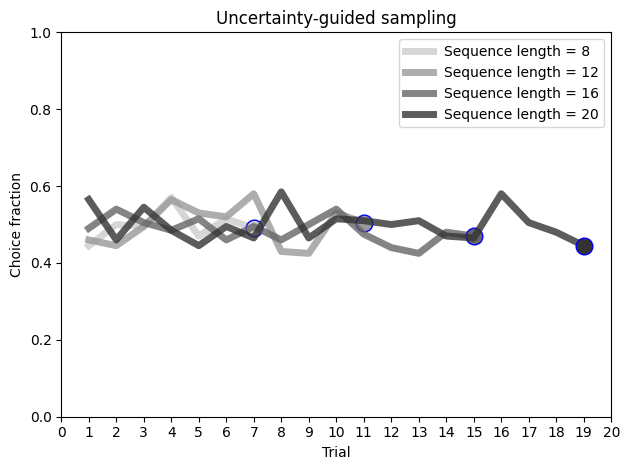

In [ ]:
def compute_uncertaintyDirectedChoice(chosen_act, cumulative_values):
    n_trials, batch_size = chosen_act.shape
    mcopt = []
    for iseq in range(batch_size):
        ch = chosen_act[:, iseq]  # Get the choices for this sequence
        cv = cumulative_values[:, iseq, :]
        # Find the index of the minimum absolute value in each row of cv
        _, tempopt = torch.min(torch.abs(cv), dim=1)  # tempopt stores indices of min values
        # Compare choices (ch) to the minimum index (tempopt)
        choice_matches = (ch == tempopt).float()  # 1 if match, 0 otherwise
        # Handle cases where abs(cv[:, 0]) == abs(cv[:, 1]) (or more generally any equal options)
        equal_mask = (torch.abs(cv[:, 0]) == torch.abs(cv[:, 1]))
        # choice_matches[equal_mask] = float('nan')  # Assign NaN to rows where options are equal
        choice_matches[equal_mask] = 1
        # Store results for this sequence
        mcopt.append(choice_matches)
    pcopt = torch.nanmean(torch.stack(mcopt, dim=1), dim=1)
    return pcopt

for i, ntrl_minibatch in enumerate(sequence_lengths):
    y = compute_uncertaintyDirectedChoice(choice[i][1:, :], cum_value[i][:-1, :])
    xtick = np.arange(1, len(y) + 1)  # xticks starting from 1
    plt.plot(xtick, y, label=f'Sequence length = {ntrl_minibatch}', color=gray_levels[i], linewidth=5, alpha=0.8)
    plt.plot(xtick[-1], y[-1], 'o', color=gray_levels[i], markersize=12, markeredgecolor='blue')

plt.legend()
plt.xticks(range(accuracy[3].shape[0]))
plt.ylim([0,1])
plt.xlabel('Trial')
plt.ylabel('Choice fraction')
plt.title('Uncertainty-guided sampling')
plt.tight_layout()
plt.show()

### Extending the Loss Function: Minimizing Belief Uncertainty

Let's explore how to minimally modify the loss function to introduce an additional objective:  
specifically, encouraging the network to **minimize the uncertainty** in its belief about the hidden states.

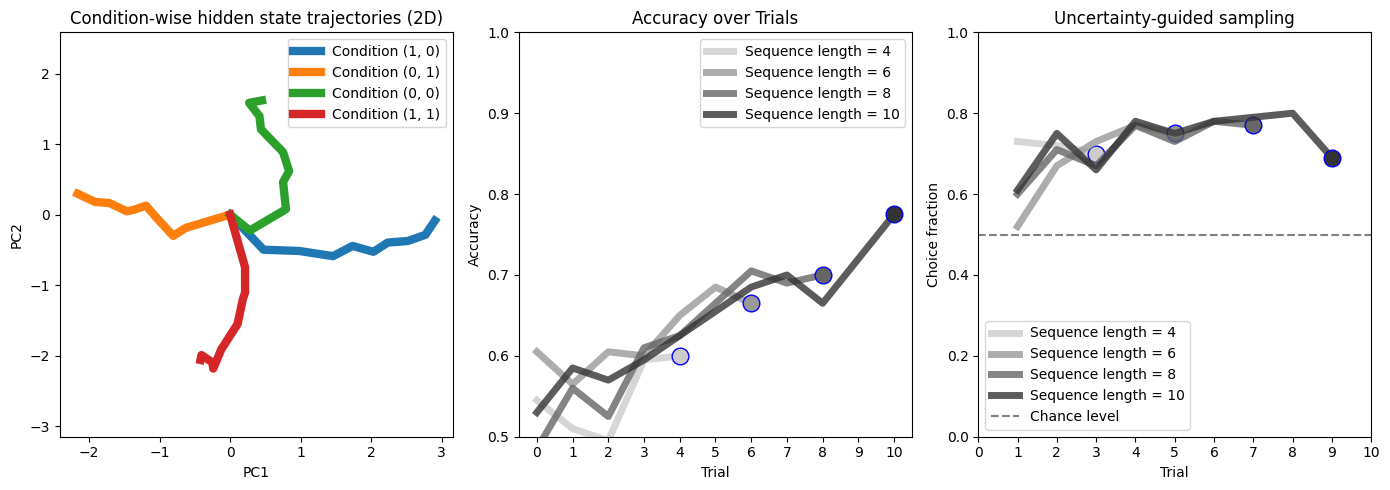

In [ ]:
# Task parameters
n_trials    = 10
n_games     = 25

# Network parameters
max_epochs   = 2000
learning_rate = 0.0005
input_size   = 2
output_size  = 3
hidden_size  = 48

conditions = [(1, 0), (0, 1), (0, 0), (1, 1)]
# Mixed four conditions: counterfactual & non-counterfactual

# Model & optimizer
rnn = vanillaRNN(input_size, hidden_size, output_size).to(device)
optimizer = optim.Adam(rnn.parameters(), lr=learning_rate, amsgrad=True, eps=1e-6)
bce_loss = nn.BCELoss()

torch.set_grad_enabled(True)

# Data containers
batch_types = ["train", "test"]
acc_totals = {bt: [] for bt in batch_types}
accTime = {bt: [] for bt in batch_types}

# Training loop
for epoch in range(max_epochs):
    for batch_type in batch_types:

        if batch_type == "train":
            rnn.train()
            optimizer.zero_grad()
            sequence_lengths = list(range(2, n_trials + 1))
        else:
            rnn.eval()
            sequence_lengths = [4, 6, 8, n_trials]  # variable-length test batches

        loss_x_ent = torch.full((len(sequence_lengths), 1), torch.nan, device=device)
        policy_loss = torch.full((len(sequence_lengths), 1), torch.nan, device=device)
        accuracy = {}
        choice = {}
        cum_value = {}

        # Loop over mini-batches of different sequence lengths
        for i, ntrl_minibatch in enumerate(sequence_lengths):

            stim1, stim2, target = generate_games(ntrl_minibatch, n_games, conditions)
            input_tensor = torch.cat((stim1.unsqueeze(2), stim2.unsqueeze(2)), dim=2)
            output = run_loop_guess(input_tensor, rnn, device)

            chosen_actions = output["chosen_actions"]

            p_states_ex = output["p_states_ex"]  # final prediction
            p_states = output["p_states"]        # intermediate predictions

            choice[i] = chosen_actions
            cum_value[i] = output["cum_value_T"]

            # cross-entorpy loss
            loss_x_ent[i] = bce_loss(p_states_ex, target)

            # Policy loss
            policies = output["policies"]
            belief_min = output["belief_min"]
            log_probs = torch.log(torch.gather(policies, 2, chosen_actions[1:,:].unsqueeze(-1)).squeeze(-1))
            weighted_log_probs = log_probs * belief_min
            policy_loss[i] = -weighted_log_probs.mean()

            # Accuracy
            target_expanded = target.unsqueeze(0).expand(ntrl_minibatch + 1, -1, -1)
            p_states_expanded = torch.cat([p_states, p_states_ex.unsqueeze(0)], dim=0)
            sampled_choice = torch.bernoulli(p_states_expanded).long()
            accuracy[i] = torch.mean((sampled_choice == target_expanded).float(), dim=(1, 2))

            hidden_actis = output["h_activat"]

        # Backpropagation
        loss = loss_x_ent.mean() + policy_loss.mean()
        if batch_type == "train":
            loss.backward()
            optimizer.step()

torch.set_grad_enabled(False)


# STEP 1: reshape hidden_actis into [n_games * n_trials, hidden_size]
Npc = 2
hidden_reshaped = hidden_actis.permute(0, 2, 1).reshape(-1, hidden_size) # shape: [n_games * n_trials, hidden_size]
# STEP 2: global PCA
_, _, V = torch.pca_lowrank(hidden_reshaped, q=hidden_size)
# STEP 3: project all hidden states
hidden_proj = torch.matmul(hidden_reshaped, V[:, :Npc])  # shape: [n_games * n_trials, Npc]
# STEP 4: reshape back to [n_games, n_trials, Npc]
n_games_actual = target.shape[0]  # Get the actual number of games from target
hidden_proj = hidden_proj.reshape(n_games_actual, n_trials, Npc) # updated with correct n_games
state_traj = {cond: torch.zeros(n_trials, Npc) for cond in conditions}

for cond in conditions:
    cond_tensor = torch.tensor(cond)
    mask = (target == cond_tensor).all(dim=1)
    idx = mask.nonzero(as_tuple=True)[0]

    if len(idx) == 0:
        continue

    # Compute trajectory in the shared PCA space
    state_traj[cond] = hidden_proj[idx].mean(0)  # mean over games


fig, axs = plt.subplots(1, 3, figsize=(14, 5))  # 1 row, 2 columns
# -------- Panel 1: Trajectories --------
for cond in conditions:
    traj = state_traj[cond]  # shape = [n_trials, 3]
    axs[0].plot(traj[:, 0], traj[:, 1], label=f"Condition {cond}", linewidth=6)

axs[0].set_xlabel('PC1')
axs[0].set_ylabel('PC2')
axs[0].set_title('Condition-wise hidden state trajectories (2D)')
axs[0].legend()
axs[0].axis('equal')

# -------- Panel 2: Accuracy curves --------
gray_levels = ['#cccccc', '#999999', '#666666', '#333333']
for i, ntrl_minibatch in enumerate(sequence_lengths):
    y = accuracy[i].cpu()
    axs[1].plot(y, label=f'Sequence length = {ntrl_minibatch}', color=gray_levels[i], linewidth=5, alpha=0.8)
    axs[1].plot(len(y)-1, y[-1], 'o', color=gray_levels[i], markersize=12, markeredgecolor='blue')

axs[1].set_xlabel('Trial')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Accuracy over Trials')
axs[1].legend()
axs[1].set_ylim([0.5, 1])
axs[1].set_xticks(range(accuracy[3].shape[0]))

for i, ntrl_minibatch in enumerate(sequence_lengths):
    y = compute_uncertaintyDirectedChoice(choice[i][1:, :], cum_value[i][:-1, :])
    xtick = np.arange(1, len(y) + 1)  # xticks starting from 1
    axs[2].plot(xtick, y, label=f'Sequence length = {ntrl_minibatch}', color=gray_levels[i], linewidth=5, alpha=0.8)
    axs[2].plot(xtick[-1], y[-1], 'o', color=gray_levels[i], markersize=12, markeredgecolor='blue')

axs[2].axhline(0.5, linestyle='--', color='gray', label='Chance level')
axs[2].legend()
axs[2].set_xticks(range(accuracy[3].shape[0]))
axs[2].set_ylim([0, 1])
axs[2].set_xlabel('Trial')
axs[2].set_ylabel('Choice fraction')
axs[2].set_title('Uncertainty-guided sampling')

plt.tight_layout()
plt.show()